In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pptx_construct
from pptx.util import Inches, Pt, Cm
from utils.pptx_params import PrsParamsManager

params = PrsParamsManager()
constructor = pptx_construct.PptxConstructor({'prs_width': Inches(13),
                                              "prs_height": Inches(7)})
chart_loc_1 = ("a", Cm(2), Cm(2), Cm(13), Cm(13))

In [3]:
df = pd.read_excel("cati.xlsx")
df = df.iloc[1:, :]

In [4]:
df.columns

Index(['樣本編號', '請問您的性別？', '請問您的年齡？', '請問您的居住地？', '請問您過去兩個月內是否在以下通路消費過？',
       'Unnamed: 5', 'Unnamed: 6', '請問您有購買過以下哪些商品(不限通路)？', 'Unnamed: 8',
       '您剛剛回答過去有購買過無鋼圈內衣，請問您購買的頻率？', '呈上題，請問最近一次購買無鋼圈內衣的品牌為？',
       '呈上題，當初購買一件的價格是多少？', '呈上題，當初在哪個通路購買？', '請問在購買無鋼圈內衣時，您覺得試穿的重要性？',
       '當您打算購買無鋼圈內衣，此時在「全聯」提供強調「舒適」的無鋼圈內衣，在不能試穿的條件下，請問您願意支付的價格會如何變化？',
       '當您打算購買無鋼圈內衣，此時在「全聯」提供強調「包覆」的無鋼圈內衣，在不能試穿的條件下，請問您願意支付的價格會如何變化？',
       '當您打算購買無鋼圈內衣，此時在「全聯」提供強調「不易變形」的無鋼圈內衣，在不能試穿的條件下，請問您願意支付的價格會如何變化？',
       '當您打算購買無鋼圈內衣，此時在「全聯」提供強調「日本專利技術」的無鋼圈內衣，在不能試穿的條件下，請問您願意支付的價格會如何變化？',
       '以下哪些方式能夠提高您在全聯購買無鋼圈內衣的意願？(最多兩項)', 'Unnamed: 19'],
      dtype='object')

In [5]:
df.columns=['id', "gender", "age", "location", "purchase_exp_1", "purchase_exp_2", "purchase_exp_3", "product_1", "product_2",
           "freq", "brand", "price", "channel", "try_importance", "comfort", "wrap", "stable", "japan", "improve_1", "improve_2"]

In [6]:
price_map = {'701~900元': 800, '300元以下': 200, '1101元以上': 1200, '301~500元': 400, '501~700元': 600, '901~1100元': 1000}
price_map_r = {price_map[k]:k for k in price_map}
freq_map = {'每年購買一次':12, '每兩年購買一次或更久':24, '每半年購買一次':6, '每三個月購買一次':3}
try_map = {"購買前不一定要試穿": 0, "購買前一定要試穿": 1}

# the minium weight is set to 0.01 to keep all information
weight = {'新北市':0.29, '桃園市':0.08, '台北市':0.15, '南投縣':0.01, '台南市':0.077,
          '嘉義縣/市':0.01, '花蓮縣':0.01, '新竹縣/市':0.01, '台中市':0.171,
          '宜蘭縣':0.01, '基隆市':0.01, '高雄市':0.148, '苗栗縣':0.01,
          '屏東縣':0.013, '彰化縣':0.027, '雲林縣':0.01, '台東縣':0.01}

In [7]:
df.age = df.age.astype(int)

# price to integer
df.price = df.price.map(lambda x: price_map[x] if x in price_map else x)

# freq to integer
df.freq = df.freq.map(lambda x: freq_map[x] if x in freq_map else x)

# try_importance to integer
df.try_importance = df.try_importance.map(lambda x: try_map[x] if x in try_map else x)

# price adjustment to integer
for col in ['comfort', 'wrap', "stable", "japan"]:
    df.loc[df[col] == '不變', col] = 0
    
    mask = df[col].str.contains("提高") & ~df[col].isnull()
    df.loc[mask, col] = df.loc[mask, col].map(lambda x: int(x.replace("提高", "").replace('元', "")))
    
    mask = df[col].str.contains("減少") & ~df[col].isnull()
    df.loc[mask, col] = df.loc[mask, col].map(lambda x: -1 * int(x.replace("減少", "").replace('元', "")))

In [8]:
# purchase exp to dummy
df['7_11'] = 0
df.loc[(df.purchase_exp_1 == "7-11(統一超商)")|(df.purchase_exp_2 == "7-11(統一超商)")|(df.purchase_exp_3 == "7-11(統一超商)"), "7_11"] = 1

df['carrefour'] = 0
df.loc[(df.purchase_exp_1 == "家樂福")|(df.purchase_exp_2 == "家樂福")|(df.purchase_exp_3 == "家樂福"), "carrefour"] = 1

# six main cities
df['six_cities'] = 0
df.loc[df.location.isin(['新北市', '桃園市', '台北市', '台南市', '台中市', '高雄市']), "six_cities"] = 1

# area
df['area'] = 'Central'
df.loc[df.location.isin(['新北市', '桃園市', '台北市', '基隆市', '新竹縣/市']), 'area'] = 'North'
df.loc[df.location.isin(['台南市', '嘉義縣/市', '屏東縣', '高雄市', '雲林縣']), 'area'] = 'South'
df.loc[df.location.isin(['台東縣', '花蓮縣', '宜蘭縣']), 'area'] = 'East'

In [9]:
# price adjustment to percentage_chagne
for col in ['comfort', 'wrap', "stable", "japan"]:
    df[f"{col}_perc"] = df[col]/df["price"]

In [10]:
# price adjustment add price to estimate price in px
for col in ['comfort', 'wrap', "stable", "japan"]:
    df[f"{col}_px"] = df[col] + df["price"]

In [11]:
total_weight = np.sum([w for w in weight.values()])
for w in weight:
    weight[w] /= total_weight
location_dist = df.location.value_counts(normalize=True)
df['weight'] = 1
for w in weight:
    df.loc[df.location == w, 'weight'] = weight[w]/location_dist[w]

In [12]:
# final weight for each location
pd.Series(weight).sort_values(ascending=False)

新北市      0.277247
台中市      0.163480
台北市      0.143403
高雄市      0.141491
桃園市      0.076482
台南市      0.073614
彰化縣      0.025813
屏東縣      0.012428
苗栗縣      0.009560
基隆市      0.009560
宜蘭縣      0.009560
雲林縣      0.009560
新竹縣/市    0.009560
花蓮縣      0.009560
嘉義縣/市    0.009560
南投縣      0.009560
台東縣      0.009560
dtype: float64

In [13]:
df.groupby('location').weight.mean()

location
南投縣      0.478011
台中市      1.307839
台北市      2.206207
台南市      0.866044
台東縣      0.956023
嘉義縣/市    0.382409
基隆市      0.318674
宜蘭縣      0.159337
屏東縣      0.355094
彰化縣      1.720841
新北市      1.498631
新竹縣/市    0.136575
桃園市      0.764818
花蓮縣      0.318674
苗栗縣      0.637349
雲林縣      0.637349
高雄市      1.230360
Name: weight, dtype: float64

In [14]:
claims = ['comfort', "wrap", "stable", "japan"]

## Function for Weighting

In [15]:
import math

def wpv_table(dataframe, index=None, columns=None, aggfunc='mean', normalize=False):
    
    data = {}
    
    if aggfunc == 'mean':
        
        if normalize:
            print('normalize is not available in the mean calculation')
        
        if isinstance(columns, str):
            columns = [columns]
        
        for col in columns:
            tmp = dataframe.loc[~dataframe[col].isnull(), :]
            if index is not None:
                data[col] = tmp.groupby(index).apply(lambda x: sum(x[col] * x['weight'])/sum(x['weight']))
            else:
                data[col] = sum(tmp[col] * tmp['weight'])/ sum(tmp['weight'])

    if aggfunc == 'size':
        category_list = dataframe[columns].dropna().unique()
        category_list.sort()
        normalize_base = 0
        for u in category_list:
            
            # use ceil to ensure the number is not shrinking to zero
            if index is not None:
                u_size = dataframe.groupby(index).apply(lambda x: math.ceil(sum((x[columns] == u).astype(int) * x['weight'])))
            else:
                u_size = math.ceil(sum((dataframe[columns] == u) * dataframe['weight']))
                
            data[u] = u_size
            normalize_base += u_size
        
        if normalize:
            if index is None:
                for d in data:
                    data[d] /= normalize_base
            else:
                print('normalize is not available multiple columns size')
        
    if index is None:    
        return pd.Series(data).sort_values(ascending=False)
                
    return pd.DataFrame(data)

## 變數分布

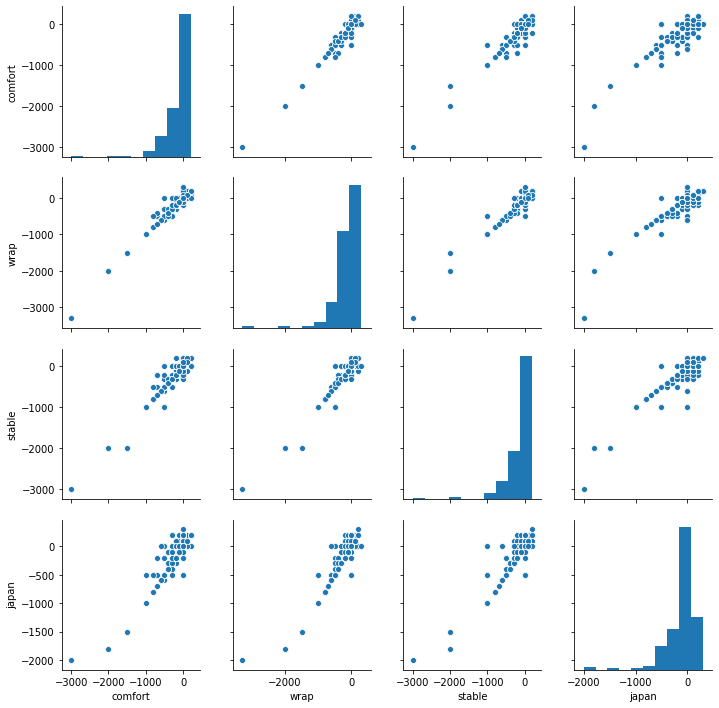

In [16]:
sns.pairplot(df.loc[:, ['comfort', "wrap", "stable", "japan"]])

In [17]:
df.corr()['freq'].sort_values()

7_11             -0.188399
stable           -0.127958
comfort          -0.107018
stable_px        -0.105117
japan            -0.098809
stable_perc      -0.098127
wrap             -0.096017
comfort_perc     -0.089960
comfort_px       -0.085502
wrap_perc        -0.084501
wrap_px          -0.073549
japan_px         -0.064153
japan_perc       -0.063079
six_cities       -0.009866
weight            0.007514
price             0.023489
carrefour         0.023596
try_importance    0.109573
age               0.156992
freq              1.000000
Name: freq, dtype: float64

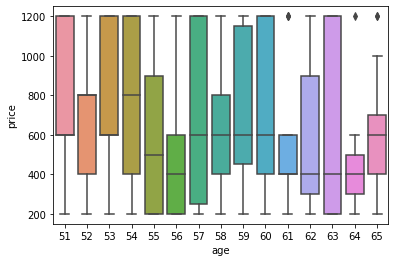

In [18]:
sns.boxplot(x="age", y="price", data=df)

In [19]:
df.loc[:, ['comfort_perc', "wrap_perc", "stable_perc", "japan_perc"]].describe()

,comfort_perc,wrap_perc,stable_perc,japan_perc
count,200.000000,200.000000,200.000000,200.000000
mean,-0.156958,-0.132167,-0.137583,-0.039583
std,0.358074,0.402779,0.387479,0.406387
min,-2.500000,-2.750000,-2.500000,-1.666667
25%,-0.333333,-0.333333,-0.333333,-0.250000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.500000,1.000000,1.500000


In [20]:
df.location.value_counts(normalize=True)

新北市      0.185
台中市      0.125
高雄市      0.115
桃園市      0.100
台南市      0.085
新竹縣/市    0.070
台北市      0.065
宜蘭縣      0.060
屏東縣      0.035
基隆市      0.030
花蓮縣      0.030
嘉義縣/市    0.025
南投縣      0.020
彰化縣      0.015
雲林縣      0.015
苗栗縣      0.015
台東縣      0.010
Name: location, dtype: float64

In [21]:
df.groupby('location').price.describe()

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
南投縣,4.0,850.000000,412.310563,400.0,550.0,900.0,1200.0,1200.0
台中市,25.0,632.000000,381.575681,200.0,200.0,600.0,1000.0,1200.0
台北市,13.0,707.692308,429.071747,200.0,400.0,400.0,1200.0,1200.0
台南市,17.0,529.411765,315.762383,200.0,400.0,400.0,600.0,1200.0
台東縣,2.0,900.000000,424.264069,600.0,750.0,900.0,1050.0,1200.0
嘉義縣/市,5.0,640.000000,357.770876,400.0,400.0,400.0,800.0,1200.0
基隆市,6.0,933.333333,326.598632,400.0,800.0,1000.0,1200.0,1200.0
宜蘭縣,12.0,716.666667,430.292360,200.0,350.0,700.0,1200.0,1200.0
屏東縣,7.0,514.285714,343.649877,200.0,300.0,400.0,600.0,1200.0


In [22]:
df.groupby('channel').price.describe()

,count,mean,std,min,25%,50%,75%,max
channel,,,,,,,,
傳統市場,35.0,314.285714,176.806403,200.0,200.0,200.0,400.0,1000.0
內衣品牌街邊店面，如:曼黛瑪璉、華歌爾、黛安芬、蕾黛絲等,31.0,825.806452,345.415443,200.0,600.0,800.0,1200.0,1200.0
內衣專賣店，如:Easyshop,26.0,692.307692,416.579478,200.0,400.0,500.0,1200.0,1200.0
其他,9.0,400.000000,264.575131,200.0,200.0,400.0,400.0,1000.0
特賣會，如:花車商品,2.0,500.000000,141.421356,400.0,450.0,500.0,550.0,600.0
百貨公司專櫃，如:微風百貨、新光三越、SOGO、遠百等,26.0,1038.461538,259.348296,400.0,1000.0,1200.0,1200.0,1200.0
網路電商平台，如:Pchome、Momo購物、Lative、其他網路品牌等,32.0,587.500000,325.031016,200.0,400.0,400.0,800.0,1200.0
"衣服品牌實體店面，如:Uniqlo,MUJI,H&M等",19.0,673.684211,268.415319,200.0,500.0,600.0,800.0,1200.0
量販店，如:家樂福、大潤發、好市多等,20.0,520.000000,351.837283,200.0,200.0,400.0,600.0,1200.0


In [23]:
df.price.value_counts(normalize=True).sort_index()

200     0.210
400     0.265
600     0.170
800     0.065
1000    0.045
1200    0.245
Name: price, dtype: float64

In [24]:
df.corr().loc[:, claims]

,comfort,wrap,stable,japan
age,0.138733,0.129363,0.136340,0.175832
freq,-0.107018,-0.096017,-0.127958,-0.098809
price,-0.589739,-0.560645,-0.546513,-0.551021
try_importance,-0.229313,-0.239749,-0.253292,-0.262249
comfort,1.000000,0.966834,0.939854,0.883888
wrap,0.966834,1.000000,0.956930,0.903252
stable,0.939854,0.956930,1.000000,0.895008
japan,0.883888,0.903252,0.895008,1.000000
7_11,-0.075765,-0.048464,-0.051651,-0.091381
carrefour,-0.142841,-0.108864,-0.083216,-0.092922


## 改善項目與購買意願

In [25]:
improve_set = []
for i, r in df.iterrows():
    if isinstance(r['improve_1'], str):
        improve_set.append(r['improve_1'])
    if isinstance(r['improve_2'], str):
        improve_set.append(r['improve_2'])
pd.Series(improve_set).value_counts(normalize=False)

有條件的退換貨         127
產品陳列在女性用品專區      57
現場有模特兒衣架展示商品     51
產品有獨立的貨架展示       46
內衣褲組合促銷          25
加贈全聯福利點數         21
一定比例捐贈女性公益團體     19
以上皆無              8
不想在全聯購買內衣         3
dtype: int64

In [26]:
improv_map = {}
ptr = 0
for imp in set(improve_set):
    df[f"imp_{ptr}"] = (df.loc[:, ['improve_1', "improve_2"]] == imp).any(1).astype(int)
    improv_map[f"imp_{ptr}"] = imp
    ptr += 1

In [27]:
for imp in improv_map:
    tmp = df[df[imp]==1]
    print(improv_map[imp], int(sum(tmp.price * tmp.weight)/sum(tmp.weight)))

產品有獨立的貨架展示 691
內衣褲組合促銷 648
產品陳列在女性用品專區 694
現場有模特兒衣架展示商品 681
加贈全聯福利點數 644
以上皆無 458
不想在全聯購買內衣 759
一定比例捐贈女性公益團體 561
有條件的退換貨 625


In [28]:
pv = wpv_table(df, index='price', columns=[f'imp_{i}' for i in range(9)])
pv.columns = pv.columns.map(lambda x: improv_map[x])
pv = pv.transpose()
pv.columns=pv.columns.map(lambda x: price_map_r[x])
constructor.add_object(data=pv, object_type='chart', position=chart_loc_1,
                       object_format={"chart_type": "stackbar", 'label_number_format': "0%"})
pv

price,300元以下,301~500元,501~700元,701~900元,901~1100元,1101元以上
產品有獨立的貨架展示,0.229063,0.120801,0.240101,0.408767,0.038284,0.269593
內衣褲組合促銷,0.080621,0.158683,0.149980,0.177600,0.284082,0.096538
產品陳列在女性用品專區,0.178442,0.372989,0.222691,0.135239,0.504109,0.340403
現場有模特兒衣架展示商品,0.276294,0.222362,0.240673,0.124535,0.337157,0.332228
加贈全聯福利點數,0.097259,0.124862,0.146662,0.108743,0.000000,0.124260
以上皆無,0.104874,0.025696,0.047639,0.000000,0.000000,0.029190
不想在全聯購買內衣,0.028460,0.000000,0.000000,0.000000,0.000000,0.032293
一定比例捐贈女性公益團體,0.112216,0.031687,0.164213,0.108743,0.016407,0.047368
有條件的退換貨,0.501219,0.740155,0.715801,0.811767,0.819961,0.495781


In [29]:
improv_map

{'imp_0': '產品有獨立的貨架展示',
 'imp_1': '內衣褲組合促銷',
 'imp_2': '產品陳列在女性用品專區',
 'imp_3': '現場有模特兒衣架展示商品',
 'imp_4': '加贈全聯福利點數',
 'imp_5': '以上皆無',
 'imp_6': '不想在全聯購買內衣',
 'imp_7': '一定比例捐贈女性公益團體',
 'imp_8': '有條件的退換貨'}

## 價格研究

In [30]:
col_comp = 'imp_3'
df.pivot_table(index=col_comp, columns='try_importance', aggfunc='size')

try_importance,0,1
imp_3,,
0,79,70
1,25,26


In [31]:
wpv_table(df[df.try_importance==0], col_comp, [f"{c}" for c in claims]) - wpv_table(df[df.try_importance==1], col_comp, [f"{c}" for c in claims])

,comfort,wrap,stable,japan
imp_3,,,,
0,174.318874,193.888439,201.337828,181.603670
1,237.083172,240.316544,265.559623,221.638922


In [32]:
for i in improv_map:
    col_comp = i
    wpvt = wpv_table(df[df.try_importance==0], col_comp, [f"{c}" for c in claims]) - wpv_table(df[df.try_importance==1], col_comp, [f"{c}" for c in claims])
    print(f"{improv_map[i]} {wpvt.mean().mean()} {wpvt.mean(1).diff()[1]}")

產品有獨立的貨架展示 336.037030832772 454.2197279281867
內衣褲組合促銷 160.66008425386823 -113.97286576445555
產品陳列在女性用品專區 213.88027996991445 34.93252151885264
現場有模特兒衣架展示商品 214.46838401343368 53.36236246190904
加贈全聯福利點數 109.42322617822803 -236.94911635823848
以上皆無 106.31277516512077 -207.9425036740921
不想在全聯購買內衣 207.14810541236034 nan
一定比例捐贈女性公益團體 101.73452112263647 -238.0039039893286
有條件的退換貨 216.27578118078162 -72.17349550214809


In [33]:
claim = "japan_px"
wpv_table(df[df[claim] > 0], columns=[claim])

japan_px    547.616362
dtype: float64

In [34]:
pv = wpv_table(df, index="brand", columns=[f"{c}_perc" for c in claims])
constructor.add_object(data=pv, object_type='table', position=chart_loc_1)
pv

,comfort_perc,wrap_perc,stable_perc,japan_perc
brand,,,,
Easyshop,-0.011615,-0.011615,0.144743,0.301100
Qmomo,-0.168921,-0.253382,-0.175686,-0.175686
Uniqlo,-0.025253,-0.009650,-0.028712,0.046972
不記得,-0.059189,-0.012232,-0.041227,-0.002927
亞曼菲,-0.158439,-0.250000,-0.250000,-0.066879
其他,-0.220848,-0.236273,-0.235175,-0.090011
曼黛瑪璉,-0.160722,-0.184951,-0.179300,-0.129296
玉如阿姨,-0.208333,-0.208333,-0.208333,-0.208333
華歌爾,-0.336764,-0.283363,-0.275068,-0.191143


In [35]:
pv = wpv_table(df, index='channel', columns='try_importance', aggfunc='size')
constructor.add_object(data=pv, object_type='chart', position=chart_loc_1,
                       object_format={"chart_type": "bar", 'label_number_format': "0"})
pv

,0,1
channel,,
傳統市場,21,16
內衣品牌街邊店面，如:曼黛瑪璉、華歌爾、黛安芬、蕾黛絲等,14,21
內衣專賣店，如:Easyshop,14,13
其他,8,2
特賣會，如:花車商品,1,0
百貨公司專櫃，如:微風百貨、新光三越、SOGO、遠百等,7,20
網路電商平台，如:Pchome、Momo購物、Lative、其他網路品牌等,18,16
"衣服品牌實體店面，如:Uniqlo,MUJI,H&M等",8,12
量販店，如:家樂福、大潤發、好市多等,11,7


In [36]:
wpv_table(df[df.try_importance==0], 
          index= "channel", 
          columns = [f"{c}_px" for c in claims]) - wpv_table(df[df.try_importance==1], "channel", [f"{c}_px" for c in claims])

,comfort_px,wrap_px,stable_px,japan_px
channel,,,,
傳統市場,-75.728294,-91.792455,-42.844320,-77.974865
內衣品牌街邊店面，如:曼黛瑪璉、華歌爾、黛安芬、蕾黛絲等,-66.300060,-3.383648,11.012488,12.334020
內衣專賣店，如:Easyshop,238.975352,235.492485,211.289248,243.444216
其他,42.454648,61.349185,61.349185,16.346472
特賣會，如:花車商品,NaN,NaN,NaN,NaN
百貨公司專櫃，如:微風百貨、新光三越、SOGO、遠百等,342.015569,385.793010,513.217004,433.476801
網路電商平台，如:Pchome、Momo購物、Lative、其他網路品牌等,-73.734920,-34.352399,-12.655334,-37.754000
"衣服品牌實體店面，如:Uniqlo,MUJI,H&M等",-142.369357,-136.949729,-180.325628,-333.035739
量販店，如:家樂福、大潤發、好市多等,137.702452,140.356862,74.445361,174.051764


In [37]:
wpv_table(df, "channel", [f"{c}_perc" for c in claims])

,comfort_perc,wrap_perc,stable_perc,japan_perc
channel,,,,
傳統市場,0.073855,0.077842,0.071679,0.141682
內衣品牌街邊店面，如:曼黛瑪璉、華歌爾、黛安芬、蕾黛絲等,-0.269385,-0.165026,-0.249379,-0.160211
內衣專賣店，如:Easyshop,-0.242865,-0.263616,-0.228672,-0.089565
其他,-0.229343,-0.153159,-0.153159,0.115502
特賣會，如:花車商品,0.000000,0.000000,0.000000,0.000000
百貨公司專櫃，如:微風百貨、新光三越、SOGO、遠百等,-0.529486,-0.492966,-0.466023,-0.384907
網路電商平台，如:Pchome、Momo購物、Lative、其他網路品牌等,-0.073042,-0.117862,-0.081048,-0.024183
"衣服品牌實體店面，如:Uniqlo,MUJI,H&M等",-0.076314,-0.068997,-0.070990,-0.035678
量販店，如:家樂福、大潤發、好市多等,-0.107557,-0.069557,-0.084483,-0.010507


In [38]:
wpv_table(df, "brand", ['price'])

,price
brand,
Easyshop,459.366277
Qmomo,906.764168
Uniqlo,542.574381
不記得,396.050280
亞曼菲,907.006042
其他,595.143792
曼黛瑪璉,792.897255
玉如阿姨,900.000000
華歌爾,982.831582


## 試穿重要性

In [39]:
wpv_table(df, "try_importance", claims)

,comfort,wrap,stable,japan
try_importance,,,,
0,-87.709970,-70.257953,-63.712953,-18.993007
1,-278.641635,-276.434962,-282.049511,-211.192146


In [40]:
wpv_table(df, "try_importance", "channel", 'size').transpose()

try_importance,0,1
傳統市場,21,16
內衣品牌街邊店面，如:曼黛瑪璉、華歌爾、黛安芬、蕾黛絲等,14,21
內衣專賣店，如:Easyshop,14,13
其他,8,2
特賣會，如:花車商品,1,0
百貨公司專櫃，如:微風百貨、新光三越、SOGO、遠百等,7,20
網路電商平台，如:Pchome、Momo購物、Lative、其他網路品牌等,18,16
"衣服品牌實體店面，如:Uniqlo,MUJI,H&M等",8,12
量販店，如:家樂福、大潤發、好市多等,11,7


In [41]:
pv = wpv_table(df, "try_importance", "brand", 'size')
pv = pv.transpose() / pv.sum(1)
pv.transpose()

,Easyshop,Qmomo,Uniqlo,不記得,亞曼菲,其他,曼黛瑪璉,玉如阿姨,華歌爾,蕾黛絲
try_importance,,,,,,,,,,
0,0.038835,0.019417,0.116505,0.310680,0.009709,0.262136,0.048544,0.000000,0.174757,0.019417
1,0.009524,0.000000,0.095238,0.266667,0.019048,0.190476,0.085714,0.019048,0.285714,0.028571


In [42]:
tmp = df.copy()
for c in claims:
    tmp.loc[tmp[f"{c}_px"] < 0, f"{c}_px"] = np.nan
pv = wpv_table(tmp, index='try_importance', columns=[f"{c}_px" for c in claims])
pv.mean(1)

try_importance
0    477.263735
1    538.935357
dtype: float64

In [43]:
df.groupby('location').try_importance.mean().sort_values()

location
屏東縣      0.142857
新竹縣/市    0.285714
苗栗縣      0.333333
雲林縣      0.333333
彰化縣      0.333333
台南市      0.352941
宜蘭縣      0.416667
新北市      0.486486
花蓮縣      0.500000
基隆市      0.500000
台北市      0.538462
桃園市      0.550000
台中市      0.560000
高雄市      0.565217
嘉義縣/市    0.600000
南投縣      0.750000
台東縣      1.000000
Name: try_importance, dtype: float64

In [44]:
df.location.unique()

array(['新北市', '桃園市', '台北市', '南投縣', '台南市', '嘉義縣/市', '花蓮縣', '新竹縣/市', '台中市',
       '宜蘭縣', '基隆市', '高雄市', '苗栗縣', '屏東縣', '彰化縣', '雲林縣', '台東縣'],
      dtype=object)

In [45]:
wpv_table(df, columns='area', aggfunc='size', normalize=True)

North      0.514851
South      0.247525
Central    0.207921
East       0.029703
dtype: float64

In [46]:
for c in claims:
    df.loc[:, f"{c}_px_cluster"] = 0
    for i in range(100, 1300, 200):
        df.loc[df[f'{c}_px'] >= i, f'{c}_px_cluster'] = i + 100

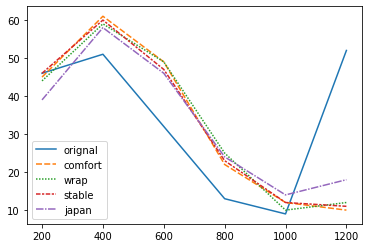

In [47]:
original_p = wpv_table(df, columns='price', aggfunc='size').sort_index().tail(6)

data = [original_p]
for c in claims:
    claim_p = wpv_table(df, columns=f'{c}_px_cluster', aggfunc='size').sort_index().tail(6)
    data.append(claim_p)
p_curve = pd.concat(data, axis=1)
p_curve.columns = ['orignal'] + claims
sns_plot = sns.lineplot(data=p_curve)

In [48]:
pv = wpv_table(df, index='price', columns='comfort_px_cluster', aggfunc='size')
pv = pv.transpose() / pv.sum(1)
pv

price,200,400,600,800,1000,1200
0,0.000000,0.000000,0.000000,0.000000,0.0,0.090909
200,0.787234,0.113208,0.029412,0.000000,0.0,0.054545
400,0.212766,0.716981,0.264706,0.142857,0.0,0.090909
600,0.000000,0.169811,0.647059,0.500000,0.2,0.218182
800,0.000000,0.000000,0.058824,0.357143,0.6,0.181818
1000,0.000000,0.000000,0.000000,0.000000,0.2,0.181818
1200,0.000000,0.000000,0.000000,0.000000,0.0,0.181818


In [49]:
wpv_table(df, columns='price', aggfunc='size', normalize=True).sort_index()

200     0.226601
400     0.251232
600     0.157635
800     0.064039
1000    0.044335
1200    0.256158
dtype: float64

In [50]:
constructor.pptx_execute()
constructor.pptx_save("test.pptx")

INFO: presentation file is saved successfully as test.pptx
